# Star Charts

The goal of this project is to create a stereographic projection of the visible hemisphere of the sky for a given time and place. The top of the chart points north, so the observer should be able to orient the chart with a compas heading.

## Data
Ingesting and processing the raw data.

 * Load the CSV using the python loader.
 * Create a struct to represent each constellation with the following properties
     * **label text** a unicode string of the text of the label **(unused)**
     * **label point** a point expressed as RA/DEC tuple in J2000 coordinates
       representing the origin of the label. Note that since the ecliptic
       is only a few degrees wide, we may be able to avoid placing any labels that cross the
       ecliptic and therefore avoid planets colliding with the constellations. **(unused)**
     * **lines** a list of two-tuples of points expressed as RA/DEC two-tuples in J2000 coordinates
     * **stars** a list of three-tuples expressed as RA/DEC and a visual magnitude
     
RA is expressed as a float in units of hours with range $[0, 24)$. DEC is also expressed as a float in degrees with range $[-90, 90]$.

## Solar system bodies

We will need a new procedure for generating the locations of solar system bodies. These can simply be an RA, DEC tuple and the label can be placed a fixed distance (in screen space) from the object it labels. TODO: do we need a data structure to represent the sun, moon, and planets?

## Coordinate conversions

To support drawing the constellation lines, we need a procedure that converts RA, DEC coordinates to screen coordinates. The procedure must be initialized with an observer location, and datetime. Some requirements revealed by the prototype include:

 * We'll use `pyephem` to convert all J2000 RA/DEC coordinates for the fixed bodies into
   the observer's horizontal coordinate system (ALT/AZ), then create the stereographic
   projection from that. We don't need to "trim" the stereographic projection since
   objects below the horizon will appear outside the masked area of the plot.
 * The conversion to cartesian coordinates places north on the positive x axis. We should
   subtract $\pi/2$ from the azimuth, modulo $2\pi$, to rotate north to the positive y
   axis.
 * The domain of the inclination parameter of the cartesian coordinate conversion
   is $[0, 2\pi]$, so the astronomical convention of $[-\pi, \pi]$ needs to be adjusted by adding $\pi$.
 * We need to consider some amount of padding so that we have room for the outer frame.

## Drawing

The drawing procedure will follow these steps:

 * Mask the area of the plot.
 * Draw a light grating indicating the lines of the equitorial corordinate system.
 * Draw the edges connecting the vertexes of the constellations.
 * Indicate the relative magnitude of the star with the radius of the dot representing it.
   First draw a slightly larger dot in the background color to provide some visual air around it.
 * Draw the labels with a wide background colored stroke behind them so that they stand out.
 
## Exclusions and deferrals
Note that there are a few things we're not going to worry about:

 * Some labels may be partially obscured by the outer edge of the chart.
 * We don't need to label the compass directions numerically.
 * It's too much to worry about the orientations of the constellation labels. They'll all be
   horizontal in the output.
 
---

## Preamble

Drawing is accomplished through the Cairo graphics library. This depends on the C library being installed. In my opinion, is most easily accomplished through Conda.

    $ conda install cairo pycairo

We will use [PyEphem](http://rhodesmill.org/pyephem/) for astrometric calculations. There is no Conda installation package, so installation is accomplished through:

    $ pip install pyephem

Early versions of this work used numpy, but the amount of data processed is small enough that plain Python data sructures are sufficiently quick while offering better flexibility.

For convenience is this notebook, images will be displayed using IPython's Image class.

In [1]:
import cairo
import csv
import ephem
import math

from IPython.display import Image
from numpy import linspace
from datetime import timedelta

## Data

The lines of the constellations come from [MidnightKite](http://www.midnightkite.com/index.aspx?AID=0&URL=StarChartFAQ). The data has been manually pared down to the International Astronomical Union's (IAU) three letter code name for the constellation, the right ascention (RA), declination (DEC), and visual magnitude (MAG).

The IAU constellation names are listed on [Wikipedia](https://en.wikipedia.org/wiki/88_modern_constellations). We're going to process this table into a dictionary so we can expand the names from the MidnightKite table.

In [2]:
class Constellation:
    '''A small mutable data structure for storing the constellation data.'''
    
    def __init__(self, label_text, label_point, lines=None, stars=None):
        self.label_text = label_text
        self.label_point = label_point
        
        if lines is None:
            self.lines = list()
        else:
            self.lines = lines

        if stars is None:
            self.stars = list()
        else:
            self.stars = list()
            
    def __repr__(self):
        return "Constellation(\"{0}\", {1}, lines={2}, stars={3})".format(
            self.label_text,
            self.label_point,
            self.lines,
            self.stars
        )

In [3]:
constellations = dict()
with open('constellation_names.csv') as csvfile:
    data = csv.DictReader(csvfile)
    for row in data:
        constellations[row['Code']] = Constellation(
            label_text = row['Name'],
            label_point = ((row['Label RA'],
                           row['Label DEC']))
        )

In [4]:
with open('ConstellationLinesAll2002.csv') as csvfile:
    data = csv.DictReader(csvfile)
    lastpoint = None
    for row in data:
        code = row['CON']
        constellation = constellations[code]
        if '' == row['RA']:
            lastpoint = None
        else:
            star = (float(row['RA']),
                    float(row['DEC']),
                    float(row['MAG']))
            constellation.stars.append(star)

            newpoint = (float(row['RA']), float(row['DEC']))
            if lastpoint is not None:
                constellation.lines.append((lastpoint, newpoint))

            lastpoint = newpoint

In [5]:
bodies = [
    ephem.Sun(),
    ephem.Mercury(),
    ephem.Venus(),
    ephem.Moon(),
    ephem.Mars(),
    ephem.Jupiter(),
    ephem.Saturn(),
    ephem.Uranus(),
    ephem.Neptune()
]

body_symbols = {
    'Sun': u'☉',
    'Venus': u'♀',
    'Mercury': u'☿',
    'Moon': u'☽',
    'Mars': u'♂',
    'Jupiter': u'♃',
    'Saturn': u'♄',
    'Uranus': u'♅',
    'Neptune': u'♆'
}

## Coordinate conversion

We need to initialize our observer with a location, date, and time. For now, let's stick to cities that PyEphem natively understands. Since PyEphem does everything in UTC, we'll also adopt that convention. The math is from the Wikipedia articles on [spherical coordinate systems](https://en.wikipedia.org/wiki/Spherical_coordinate_system) and [stereographic projection](https://en.wikipedia.org/wiki/Stereographic_projection).

$$ \begin{equation} \begin{split} \\
x & = r \sin \theta \cos \phi \\
y & = r \sin \theta \sin \phi \\
z & = r \cos \theta \\
(X, Y) & = \left( \frac{x}{1-z},\frac{y}{1-z} \right) \\
\end{split} \end{equation}
$$

In [6]:
def make_radec2cart(observer):
    # This is probably not thread safe
    fb = ephem.FixedBody()
    def radec2cart(ra, dec):
        # If ephem.hours or degrees sees a float, it believes it's already a measure in radians.
        fb._ra = ephem.hours(str(ra))
        fb._dec = ephem.degrees(str(dec))
        fb.compute(observer)

        # TODO investigate if some of the normalization can be handled by PyEphem's anorm property
        
        # fix the range from [-90, 90] degrees to [0, 180] degrees
        alt = fb.alt + math.pi/2.0

        # The Horizontal azimuth is measured clockwise from 0 degrees north, so we need to change
        # the sign and rotate by a quarter turn.
        az = ((math.pi*2 - fb.az) - math.pi/2 ) % (math.pi*2)

        sin_alt = math.sin(alt)
        x = sin_alt * math.cos(az)
        y = sin_alt * math.sin(az)
        z = math.cos(alt)
        X = x / (1 - z)
        Y = y / (1 - z)
        return (X, Y)
    return radec2cart

## Drawing

We can divide this into discrete procedures...

 * Scale and clip (repeated in drawing procedures)
 * Draw the grid
 * Draw the constellations
 * Draw the planets
 * Draw centered text
 * Draw the labels (no scale/clip)

In [27]:

def scale_and_clip(ctx, pos_x, pos_y, radius):
    '''Call Context.save before and Context.restore() and Context.reset_clip() afterwards.'''
    ctx.translate(pos_x, pos_y)
    ctx.scale(radius, radius)
    ctx.arc(0, 0, 1, 0, math.pi*2)
    ctx.clip()

def line_width(ctx, width):
    '''Only works with scaling in the x direction.'''
    return ctx.device_to_user_distance(width, 0)[0]
    
def draw_grid(ctx, radec2cart):
    ctx.set_source_rgb(0, 0, 0)
    ctx.set_line_width(line_width(ctx, 1.5))

    for ra in linspace(0, 24, 24):
        first = True
        for dec in linspace(-90, 90, 180):
            if first:
                ctx.move_to(*radec2cart(ra, dec))
                first = False
            else:
                ctx.line_to(*radec2cart(ra, dec))

    for dec in linspace(-90, 90, 18):
        first = True
        for ra in linspace(0, 24, 240):
            if first:
                ctx.move_to(*radec2cart(ra, dec))
                first = False
            else:
                ctx.line_to(*radec2cart(ra, dec))
    
    ctx.stroke()

def draw_constellations(ctx, constellations, radec2cart):
    ctx.set_source_rgb(0,0,0)
    ctx.set_line_width(line_width(ctx, 2.5))

    for constellation in constellations.values():
        for line in constellation.lines:
            ctx.move_to(*radec2cart(line[0][0], line[0][1]))
            ctx.line_to(*radec2cart(line[1][0], line[1][1]))
    ctx.stroke()

def draw_stars(ctx, constellations, radec2cart):
    for constellation in constellations.values():
        for star in constellation.stars:
            pos = radec2cart(star[0], star[1])

            radius = line_width(ctx, 8 - star[2]/2)

            ctx.set_source_rgb(1, 1, 1)
            ctx.arc(pos[0], pos[1], radius, 0, math.pi*2)
            ctx.fill()
            ctx.set_source_rgb(0,0,0)
            ctx.arc(pos[0], pos[1], radius-line_width(ctx, 2), 0, math.pi*2)
            ctx.fill()

    
def draw_bodies(ctx, bodies, radec2cart):
    ctx.select_font_face('Apple Symbols')
    ctx.set_font_size(line_width(ctx, 96))
    ctx.set_line_width(line_width(ctx, 10))
    for body in bodies:
        pos = radec2cart(body.ra, body.dec)
        name = body_symbols[body.name]
        ext = ctx.text_extents(name)
        ctx.move_to(pos[0] - ext.width/2, pos[1] + ext.height/2)
        ctx.text_path(name)
        ctx.set_source_rgb(1,1,1)
        ctx.stroke_preserve()
        ctx.fill_preserve()
        ctx.set_source_rgb(0,0,0)
        ctx.fill()

def label_latlon(lat, lon):
    '''Format ephem angles for latitude and longitude with appropriate tickmarks.'''
    return "{lat[0]}°{lat[1]}'{lat[2]}\" / {lon[0]}°{lon[1]}'{lon[2]}\"".format(
        lat=str(lat).split(":"),
        lon=str(lon).split(":"))

def label_date(ephemdate, utc_offset):
    d = ephemdate.datetime()
    td = timedelta(hours=utc_offset)
    return (d + td).strftime('%A %e %B %Y, %I:%M %p')

def draw_labels(ctx, observer, utcoffset, pos_x, pos_y):
    label_text = label_latlon(observer.lat, observer.lon)
    label_date_text = label_date(observer.date, utcoffset)
    
    ctx.select_font_face('Cormorant Garamond')
    ctx.set_font_size((10/72)*300)
    ctx.set_source_rgb(0,0,0)

    ext = ctx.text_extents(label_date_text)
    ctx.move_to(pos_x - ext.width/2, pos_y)
    ctx.show_text(label_date_text)

    ext = ctx.text_extents(label_text)
    ctx.move_to(pos_x - ext.width/2, pos_y+(12/72)*300)
    ctx.show_text(label_text)

def create_star_chart(filename, constellations, bodies, observer, utc_offset, width, height, radius):

    radec2cart = make_radec2cart(observer)

    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, width, height)
    ctx = cairo.Context(surface)

    # Fill the canvas with white
    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0, 0, width, height)
    ctx.fill()

    ctx.save()

    scale_and_clip(ctx, width/2, width/2, radius)

    draw_grid(ctx, radec2cart)
    draw_constellations(ctx, constellations, radec2cart)
    draw_stars(ctx, constellations, radec2cart)
    draw_bodies(ctx, bodies, radec2cart)    

    ctx.reset_clip()
    ctx.set_source_rgb(0,0,0)
    ctx.arc(0,0,1,0, math.pi*2)
    ctx.set_line_width(line_width(ctx,4))
    ctx.stroke()

    ctx.restore()

    draw_labels(ctx, observer, utc_offset, width/2, height-300)

    surface.write_to_png(filename)

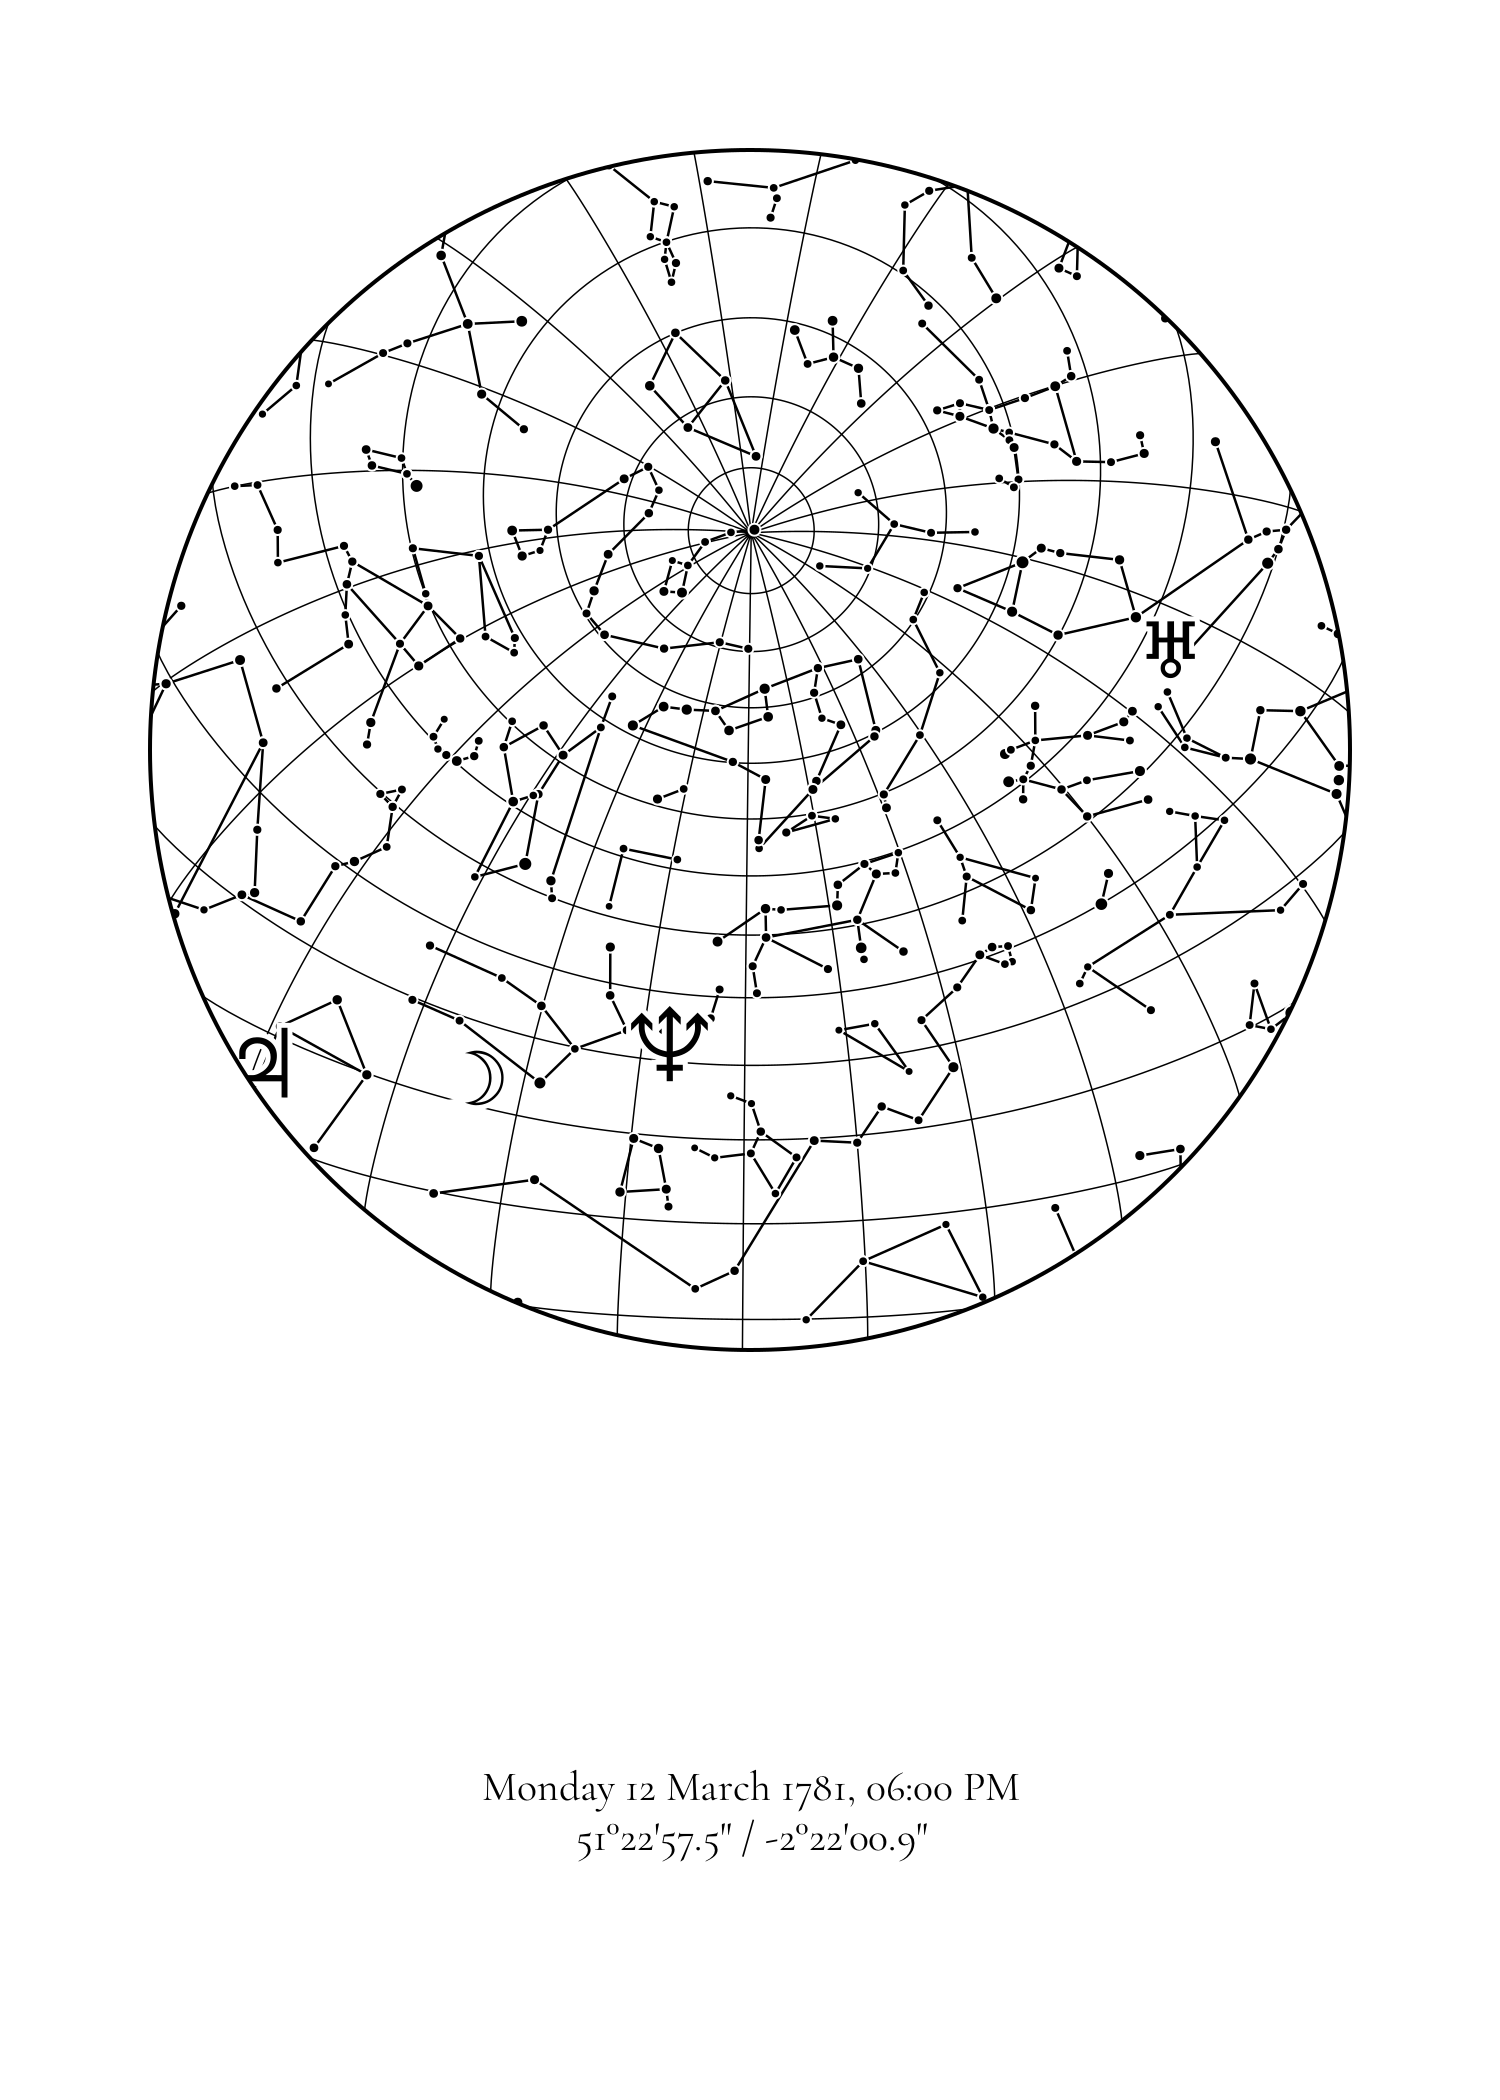

In [29]:
observer = ephem.Observer()
observer.lat = "51.382642"
observer.lon = "-2.366914"
observer.date = '1781/03/13 00:00:00'

# This is an odd detail... how to handle this?
for body in bodies:
    body.compute(observer)

filename = '1781_Mar_13_grid_5x7.png'

create_star_chart(
    filename=filename,
    constellations=constellations,
    bodies=bodies,
    observer=observer,
    utc_offset=-6,
    width=5*300,
    height=7*300,
    radius=int(2*300))
    
Image(filename, retina=True)

This is t

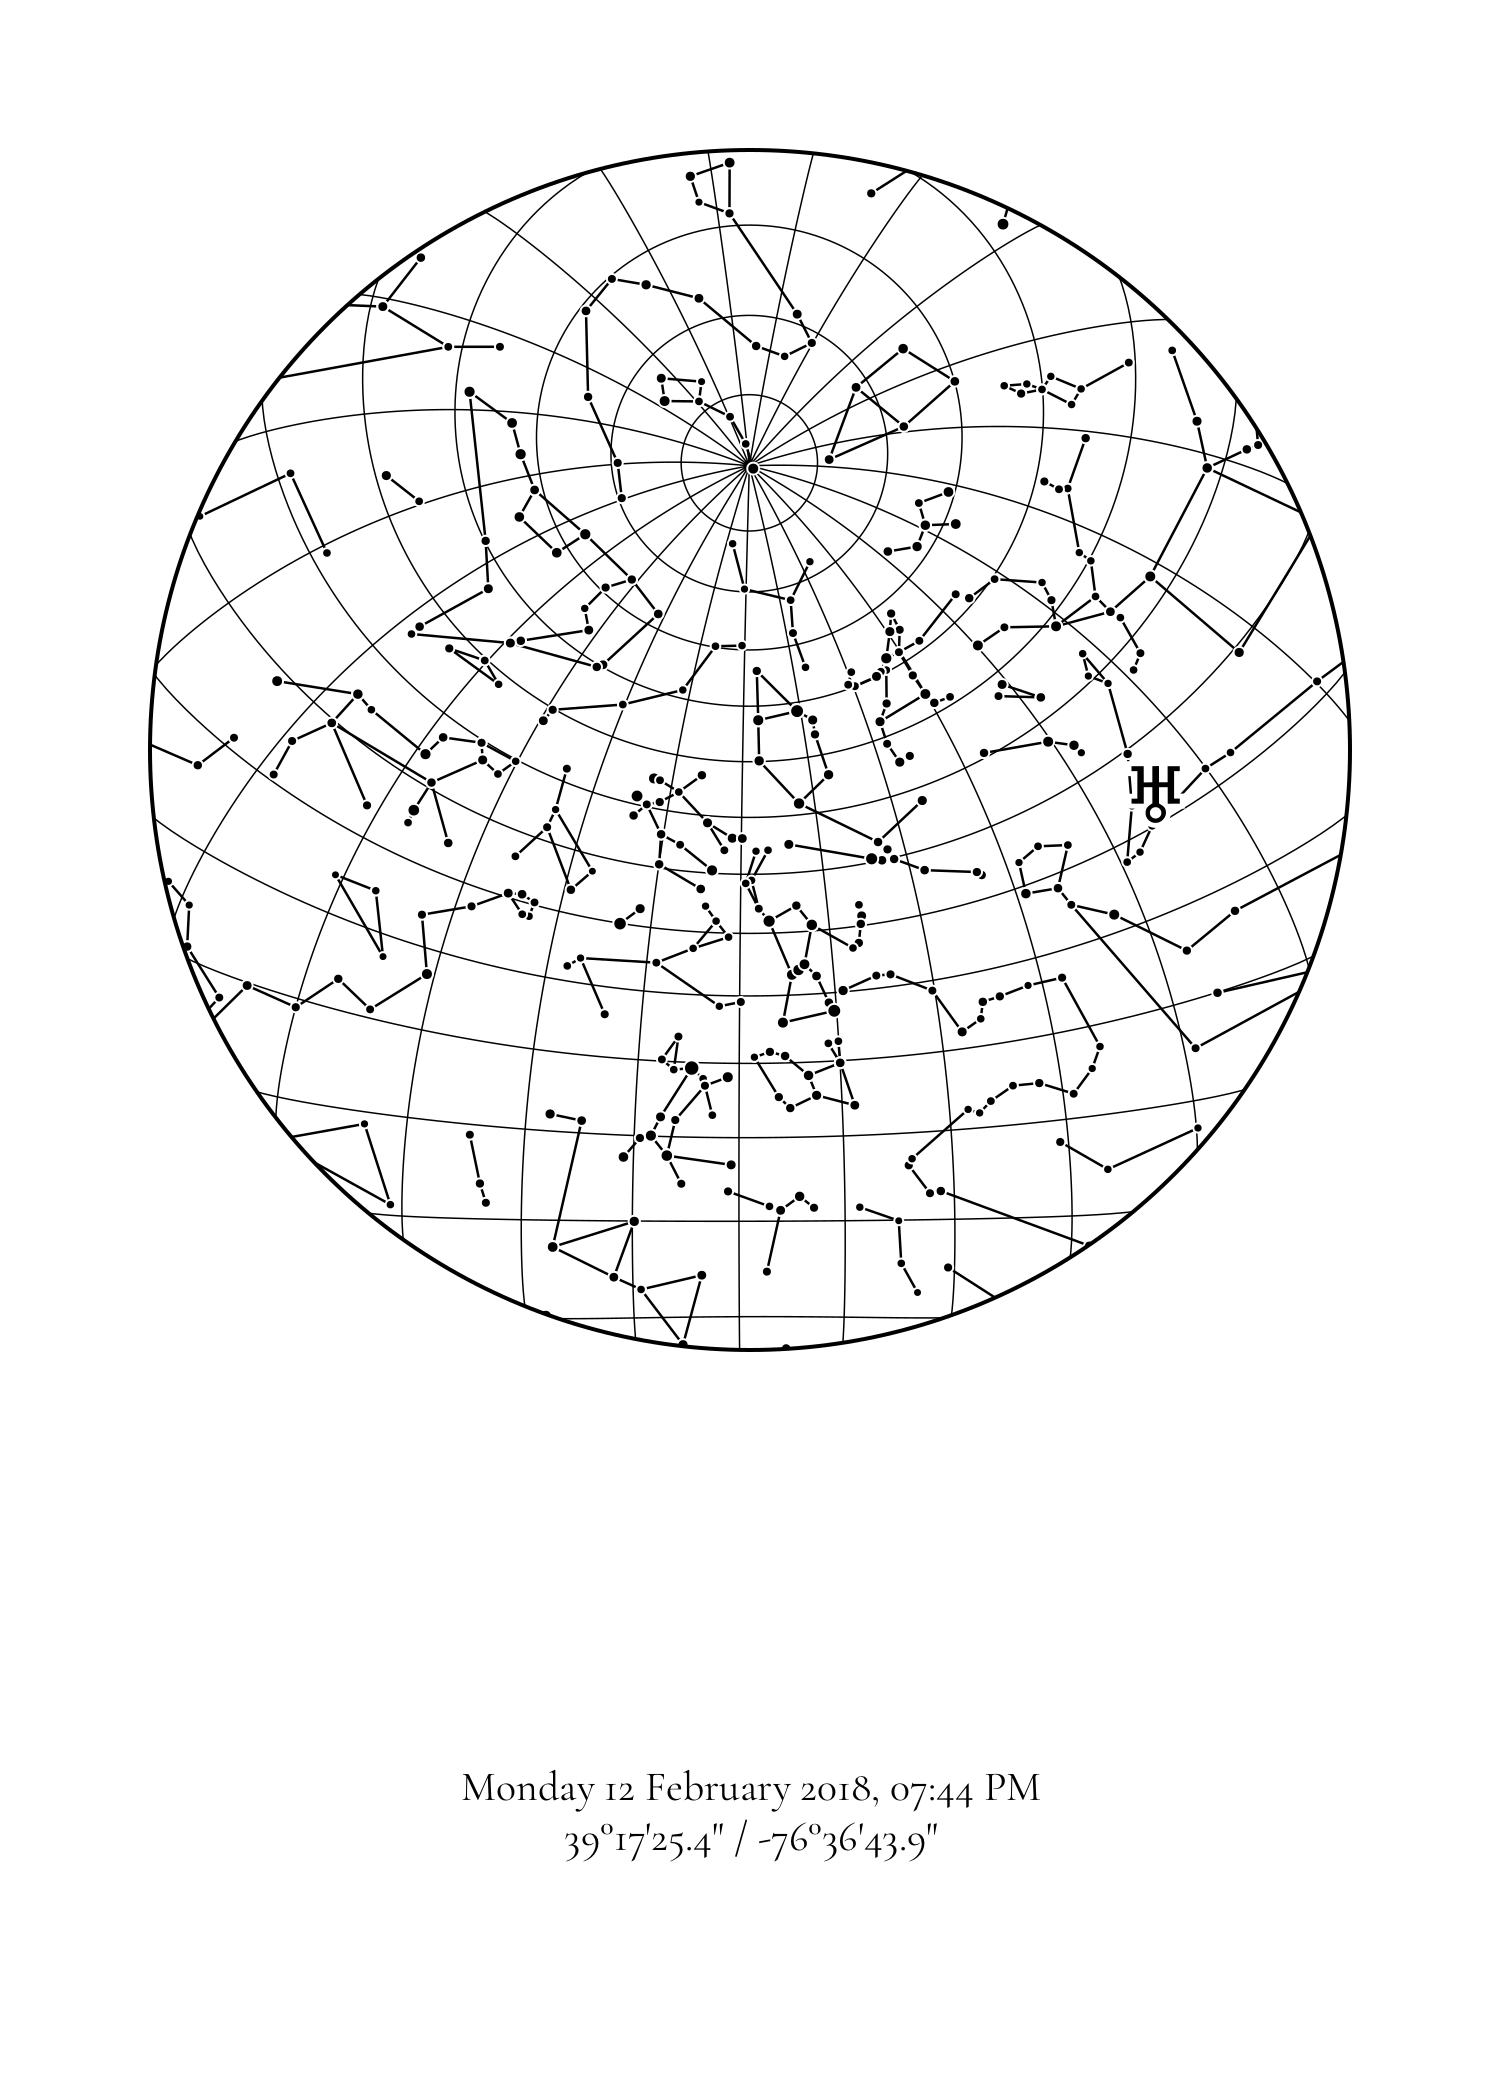

In [31]:
observer = ephem.city('Baltimore')
observer.date = '2018/02/13 01:44:00'

# This is an odd detail... how to handle this?
for body in bodies:
    body.compute(observer)

filename = '2018_Feb_12_grid_5x7.png'

create_star_chart(
    filename=filename,
    constellations=constellations,
    bodies=bodies,
    observer=observer,
    utc_offset=-6,
    width=5*300,
    height=7*300,
    radius=int(2*300))
    
Image(filename, retina=True)